In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import h3
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.feature_selection import RFECV
import shap

In [2]:
pd.options.display.max_columns = None

In [3]:
%load_ext autoreload
%autoreload 2

## Data

In [ ]:
gdf1 = gpd.read_parquet('data/train/buildings-primary.parquet')
gdf2 = gpd.read_parquet('data/train/buildings-secondary.parquet')
candidate_pairs = pd.read_csv('data/train/labels.csv')
candidate_pairs['match'] = candidate_pairs['match'] == 'yes'

## Feature engineering

In [ ]:
from conflation.alignment import correct_local_shift
from conflation.feateng import calculate_matching_features

print("(1) Spatially aligning datasets...")
gdf2["geometry"] = correct_local_shift(gdf1, gdf2, h3_res=9)

print("(2) Calculating matching features...")
candidate_pairs = calculate_matching_features(gdf1, gdf2, candidate_pairs)

(1) Spatially aligning datasets...
Correcting misaligned for 78.9% 


2025-09-25 15:08:50 INFO     Preprocessing geometry...


(2) Calculating matching features...


2025-09-25 15:10:55 INFO     Determining blocks...


Generated 388641 blocks with on average 1.8 buildings.
Generated 408372 blocks with on average 1.4 buildings.


2025-09-25 15:17:08 INFO     Calculating building shape characteristics...
2025-09-25 15:17:08 INFO     Calculating similarity characteristics...
2025-09-25 15:17:11 INFO     Joining characteristics...
2025-09-25 15:17:11 INFO     Calculating context features...


In [72]:
candidate_pairs.to_parquet("data/train/candidate-pairs-w-fts.parquet")

# from shapely import wkb
# candidate_pairs = pd.read_parquet("data/train/candidate-pairs-w-fts.parquet")
# candidate_pairs = gpd.GeoDataFrame(candidate_pairs)

# for col in candidate_pairs.columns:
#     if 'geometry' in col:
#         candidate_pairs[col] = gpd.GeoSeries(candidate_pairs[col].apply(wkb.loads), crs=3035)


## Training

In [46]:
XGBOOST_PARAMS = {'tree_method': 'hist', 'objective': 'binary:logistic'}
HYPERPARAMETERS = {
    'colsample_bytree': 0.7,
    'subsample': 0.7,
}

In [57]:
bldg_features = [
    'bldg_footprint_area',
    'bldg_perimeter',
    'bldg_longest_axis_length',
    'bldg_elongation',
    'bldg_orientation',
    'bldg_area_perimeter_ratio',
    'bldg_shape_index',
]

similarity_features = [
    'diff_bldg_footprint_area',
    'diff_bldg_perimeter',
    'diff_bldg_longest_axis_length',
    'diff_bldg_elongation',
    'diff_bldg_orientation',
    'diff_bldg_area_perimeter_ratio',
    'diff_bldg_shape_index',
    'bldg_distance',
    'bldg_distance_centroids',
    'bldg_wall_alignment',
    'bldg_shared_walls',
    'block_distance',
    'block_distance_centroids',
    'block_wall_alignment',
    'block_shared_walls',
]
intersection_features = [
    'bldg_intersection',  # renamed to ioa
    'bldg_ioa',
    'bldg_iou',
    'bldg_aligned_iou',
    'block_intersection',  # renamed to ioa
    'block_ioa',  # renamed to iosa
    'block_iou',
    'block_aligned_iou',
]
context_features = [
    'area_share_intersected',
    'area_share_intersected_others',
    'alignment',
]

In [58]:
candidates = candidate_pairs.copy()

fts = (
    bldg_features +
    similarity_features +
    intersection_features +
    context_features
)

X = candidates[fts]
y = candidates['match']

kfold = KFold(n_splits=5, shuffle=True, random_state=1)
model = xgb.XGBClassifier(random_state=42, **HYPERPARAMETERS, **XGBOOST_PARAMS)
model.fit(X, y)

candidates['match_xgb'] = cross_val_predict(model, X, y, cv=kfold)

f1_score = metrics.f1_score(y, candidates['match_xgb'])
report = metrics.classification_report(candidates['match'], candidates['match_xgb'])

print(f"F1 score: {f1_score:.4f}")
print(report)

F1 score: 0.9577
              precision    recall  f1-score   support

       False       0.88      0.82      0.85       355
        True       0.95      0.97      0.96      1207

    accuracy                           0.93      1562
   macro avg       0.91      0.89      0.90      1562
weighted avg       0.93      0.93      0.93      1562



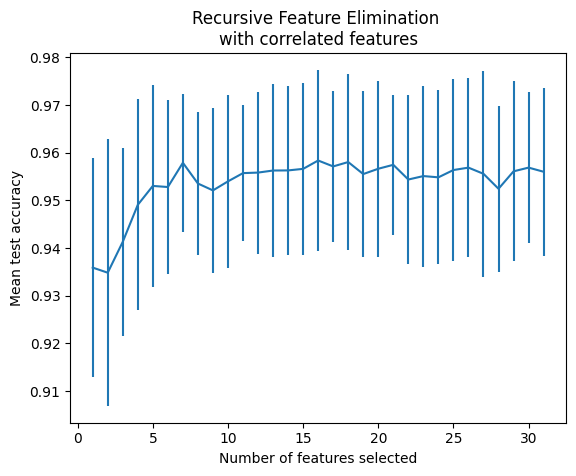

In [ ]:
rfe = RFECV(model, step=1, cv=5, scoring='f1')
rfe.fit(X, y)
selected_fts = candidates[fts].columns[rfe.support_]

# cv_results = pd.DataFrame(rfe.cv_results_)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    x=rfe.cv_results_["n_features"],
    y=rfe.cv_results_["mean_test_score"],
    yerr=rfe.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()


## Model evaluation

In [59]:
gdf_gov = gpd.read_parquet('data/aaai/buildings-gov.parquet')
gdf_osm = gpd.read_parquet('data/aaai/buildings-osm.parquet')
gdf_msft = gpd.read_parquet('data/aaai/buildings-msft.parquet')
df_pairs_val = pd.read_parquet('data/aaai/matching-pairs.parquet') 


In [60]:
def drop_buildings_elsewhere(
    gdf1: gpd.GeoDataFrame, gdf2: gpd.GeoDataFrame, pairs: pd.DataFrame
) -> tuple[gpd.GeoDataFrame, gpd.GeoDataFrame]:
    """
    Remove buildings away from the candidate pairs.
    Buildings within h3 grid cell and direct neighboring cells are kept.
    """
    nbh1 = pairs["id_existing"].map(gdf1["neighborhood"])
    nbh2 = pairs["id_new"].map(gdf2["neighborhood"])
    nbh = pd.concat([nbh1, nbh2]).unique()
    nbh_w_neighbors = _h3_disk(nbh, k=1)

    gdf1 = gdf1[gdf1["neighborhood"].isin(nbh_w_neighbors)]
    gdf2 = gdf2[gdf2["neighborhood"].isin(nbh_w_neighbors)]

    return gdf1, gdf2


def _h3_disk(h3_indices: list[str], k: int) -> list[str]:
    """
    Determines all nearby cells for a list of h3 indices within k grid distance.
    """
    return np.unique(np.ravel([h3.grid_disk(idx, k) for idx in h3_indices]))

In [61]:
conflation_pairs = {
    'gov-osm': (gdf_gov, gdf_osm),
    'gov-msft': (gdf_gov, gdf_msft),
    'osm-msft': (gdf_osm, gdf_msft)
}
pairs_w_fts = []

for name, (gdf1, gdf2) in conflation_pairs.items():
    print(f"(1) Loading candidate pairs for {name}...")
    pairs = df_pairs_val[df_pairs_val['datasets'] == name].copy()
    gdf1 = gdf1.copy()
    gdf2 = gdf2.copy()

    print("(2) Storing original geometries for later analysis...")
    pairs["original_geometry_existing"] = gpd.GeoSeries(pairs["id_existing"].map(gdf1.geometry))
    pairs["original_geometry_new"] = gpd.GeoSeries(pairs["id_new"].map(gdf2.geometry))

    print("(3) Dropping buildings in areas without candidate pairs (e.g. where no gov data is available)...")
    print(len(gdf1), len(gdf2), len(pairs))
    gdf1, gdf2 = drop_buildings_elsewhere(gdf1, gdf2, pairs)
    print(len(gdf1), len(gdf2), len(pairs))

    print("(4) Spatially aligning datasets...")
    gdf2["geometry"] = correct_local_shift(gdf1, gdf2, h3_res=9)

    print("(5) Calculating matching features...")
    pairs = calculate_matching_features(gdf1, gdf2, pairs)

    pairs_w_fts.append(pairs)

candidate_pairs_val = pd.concat(pairs_w_fts, ignore_index=True)


(1) Loading candidate pairs for gov-osm...
(2) Storing original geometries for later analysis...
(3) Dropping buildings in areas without candidate pairs (e.g. where no gov data is available)...
2454 3195 2594
2394 1968 2594
(4) Spatially aligning datasets...
Correcting misaligned for 31.6% 


2025-09-25 15:29:38 INFO     Preprocessing geometry...


(5) Calculating matching features...


2025-09-25 15:29:39 INFO     Determining blocks...


Generated 1465 blocks with on average 1.6 buildings.


2025-09-25 15:29:40 INFO     Calculating building shape characteristics...


Generated 1201 blocks with on average 1.6 buildings.


2025-09-25 15:29:40 INFO     Calculating similarity characteristics...
2025-09-25 15:29:50 INFO     Joining characteristics...
2025-09-25 15:29:50 INFO     Calculating context features...


(1) Loading candidate pairs for gov-msft...
(2) Storing original geometries for later analysis...
(3) Dropping buildings in areas without candidate pairs (e.g. where no gov data is available)...
2454 3153 2690
2454 1718 2690
(4) Spatially aligning datasets...
Correcting misaligned for 96.6% 


2025-09-25 15:29:53 INFO     Preprocessing geometry...


(5) Calculating matching features...


2025-09-25 15:29:53 INFO     Determining blocks...


Generated 1518 blocks with on average 1.6 buildings.


2025-09-25 15:29:55 INFO     Calculating building shape characteristics...


Generated 1486 blocks with on average 1.2 buildings.


2025-09-25 15:29:55 INFO     Calculating similarity characteristics...
2025-09-25 15:30:02 INFO     Joining characteristics...
2025-09-25 15:30:02 INFO     Calculating context features...


(1) Loading candidate pairs for osm-msft...
(2) Storing original geometries for later analysis...
(3) Dropping buildings in areas without candidate pairs (e.g. where no gov data is available)...
3195 3153 4400
3195 3153 4400
(4) Spatially aligning datasets...
Correcting misaligned for 76.6% 


2025-09-25 15:30:05 INFO     Preprocessing geometry...


(5) Calculating matching features...


2025-09-25 15:30:06 INFO     Determining blocks...


Generated 2079 blocks with on average 1.5 buildings.


2025-09-25 15:30:08 INFO     Calculating building shape characteristics...


Generated 2741 blocks with on average 1.2 buildings.


2025-09-25 15:30:08 INFO     Calculating similarity characteristics...
2025-09-25 15:30:18 INFO     Joining characteristics...
2025-09-25 15:30:18 INFO     Calculating context features...


In [ ]:
# train model
X = candidates[fts]
y = candidates['match']

model = xgb.XGBClassifier(random_state=99, **HYPERPARAMETERS, **XGBOOST_PARAMS)
model.fit(X, y)
model.save_model('data/train/xgboost-model-eubucco-v1.json')


X_val = candidate_pairs_val[fts]
y_val = candidate_pairs_val['match']

candidate_pairs_val['match_xgb'] = model.predict(X_val).astype(bool)

# retrain model on val set
# kfold = KFold(n_splits=5, shuffle=True, random_state=1)
# candidate_pairs_val['match_xgb'] = cross_val_predict(model, X_val, y_val, cv=kfold)

report = metrics.classification_report(y_val, candidate_pairs_val['match_xgb'])
f1_score = metrics.f1_score(y_val, candidate_pairs_val['match_xgb'])

print(f"F1 score: {f1_score:.4f}")
print(report)


F1 score: 0.9957
              precision    recall  f1-score   support

       False       0.99      0.98      0.99      2459
        True       0.99      1.00      1.00      7225

    accuracy                           0.99      9684
   macro avg       0.99      0.99      0.99      9684
weighted avg       0.99      0.99      0.99      9684



### Baseline intersection-based matching

In [ ]:
from conflation.feateng import  compute_ioa, compute_iou

candidate_pairs_val['ioa'] = compute_ioa(candidate_pairs_val['original_geometry_existing'], candidate_pairs_val['original_geometry_new'])
candidate_pairs_val['iou'] = compute_iou(candidate_pairs_val['original_geometry_existing'], candidate_pairs_val['original_geometry_new'])

candidate_pairs_val['match_iou'] = candidate_pairs_val['iou'] > 0.5
candidate_pairs_val['match_ioa'] = candidate_pairs_val['ioa'] > 0.5

### Matching method evaluation

In [66]:
metrics_matching =['iou', 'ioa', 'xgb']

# for metric in metrics_matching:
#     f1 = metrics.f1_score(candidate_pairs_val['match'], candidate_pairs_val[f'match_{metric}'])
#     print(f'F1 score for metric "{metric}": {f1:.3f}')

#     print(f'Classification report for metric "{metric}"')
#     report = metrics.classification_report(candidate_pairs_val['match'], candidate_pairs_val[f'match_{metric}'])
#     print(report)


results = []
for metric in metrics_matching:
    y_true = candidate_pairs_val['match']
    y_pred = candidate_pairs_val[f'match_{metric}']
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    f1 = metrics.f1_score(y_true, y_pred)
    
    row = {
        'Metric': metric,
        'Precision': round(precision, 2),
        'Recall': round(recall, 2),
        'F1 Score': round(f1, 2)
    }

    # Dataset-specific F1 scores
    dataset_scores = candidate_pairs_val.groupby('datasets').apply(
        lambda g: metrics.f1_score(g['match'], g[f'match_{metric}'])
    )

    for dataset, score in dataset_scores.items():
        row[f'F1 ({dataset})'] = round(score, 2)

    results.append(row)

results_df = pd.DataFrame(results)
results_df = results_df.set_index('Metric')
results_df

,Precision,Recall,F1 Score,F1 (gov-msft),F1 (gov-osm),F1 (osm-msft)
Metric,,,,,,
iou,1.00,0.43,0.60,0.52,0.77,0.52
ioa,1.00,0.88,0.94,0.93,0.95,0.93
xgb,0.99,1.00,1.00,0.99,1.00,0.99


In [71]:
latex_table = results_df[['Precision', 'Recall', 'F1 Score', 'F1 (gov-msft)', 'F1 (gov-osm)', 'F1 (osm-msft)']].to_latex(
    'manuscript/eubucco/matching_accuracy.tex',
    float_format="%.2f",
    column_format="l" + "r" * (len(results_df.columns)),
    bold_rows=True,
    caption="Performance of Matching Metrics by Dataset",
    label="tab:matching_metrics"
)

### Explanability

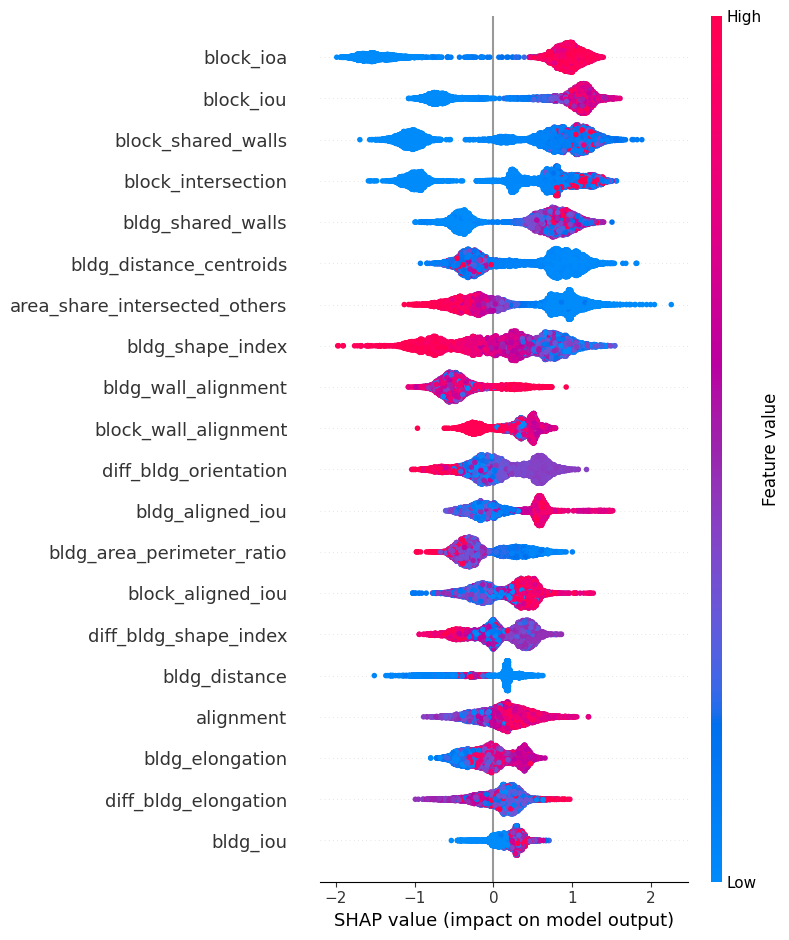

In [ ]:
explainer = shap.Explainer(model)
shap_values = explainer(X_val)

# Summary plot of feature importance
shap.summary_plot(shap_values, X_val, feature_names=fts)